# Crypto Currency Analysis

Crpytocurrency exchanges are websites that enable the purchase, sale, and exchange of crypto and traditional currencies. These exchanges serve the essential functions of providing liquidity for owners and establishing the relative of these currencies. As of this writing (mid-2022), [it is estimated](https://www.statista.com/statistics/730876/cryptocurrency-maket-value/) that crypocurrencies have a collective market capitalization of more than 2 trillion USD. 

The purpose of this notebook is to explore the efficiency of these exchanges by testing. An arbitrage exists on an exchange if, through a risk-free series of trades, a customer could realize a net profit. The efficient market hypothesis assumes any sustained arbitrage opportunities would be identified by investors and, as result of their trading, quickly wiped as prices reach a new equilibrium. In an efficient market, any arbitrage would be small and fleeting. Still, the market has to get to equilibrium somehow, so perhaps with real-time data and rapid execution, can a trader put themself in a position to profit from these fleeting market adjustments?

## Bibliographic Notes

Crytocurrency markets are still a relatively new and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf





## Installations and Imports

This notebook requires multiple libraries. The following cell performs the required installations for Google Colab. To operate your own device you will need to install the `pyomo`,`ccxt`, and `graphviz` python libraries, the graphviz executables, and a linear solver for Pyomo.

In [20]:
import sys

if "google.colab" in sys.modules:
    !pip install -q ccxt
    !pip install -q netgraph
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [21]:
import os
from time import time
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import pyomo.environ as pyo

## Cryptocurrency Exchanges

The [open-source library `ccxt`](https://github.com/ccxt/ccxt) currently supports real-time APIs for 114 exchanges on which cryptocurrencies are traded. Here we import the library and list current exchanges supported by `ccxt`.

In [22]:
import ccxt

print(ccxt.exchanges)

['aax', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bkex', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'buda', 'bw', 'bybit', 'bytetrade', 'cdax', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinspot', 'crex24', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'eqonex', 'exmo', 'flowbtc', 'fmfwio', 'ftx', 'ftxus', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'itbit', 'kraken', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'liquid', 'luno', 'lykke', 'mercado', 'mexc', 'ndax', 'novadax', 'oceanex',

## Exchange markets and symbols

Each of the exchanges supported by `ccxt` offers multiple markets, each market consisting of trade between two (possibly more) currencies. `ccxt` labels each market with a symbol and market id. The market id is for HTTP request-response purposes and not relevant to this analysis. The symbol, however, is common across exchanges and suitable for arbitrage and other cross-exchange analyses.

Each symbol is an upper case string with names for a pair of traded currencies separated by a slash. The first name is the base currency, the second name is the quote currency. 

The following cell creates a directed graph to visualize the markets available on a single exchange. The directed graph consists of nodes representing currencies, and edges trading between those currencies. The symbol for each market forms an edge with the source located at the quote currency and directed towards a destination at the base currency.

In [29]:
import ccxt
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph

# global variables used in subsequent cells
exchange = ccxt.binanceus()
markets = exchange.load_markets()
symbols = exchange.symbols


def symbols_to_dg(symbols, in_degree=1):

    dg = nx.DiGraph()
    for base, quote in [symbol.split("/") for symbol in symbols]:
        dg.add_edge(quote, base)

    for node in dg.nodes():
        if dg.out_degree(node) > 0:
            dg.nodes[node]["color"] = "gold"
        else:
            dg.nodes[node]["color"] = "lightblue"

    remove_nodes = []
    for node in [node for node in dg.nodes() if dg.out_degree(node) == 0]:
        if dg.in_degree(node) <= in_degree:
            remove_nodes.append(node)
    dg.remove_nodes_from(remove_nodes)

    return dg


dg_symbols = symbols_to_dg(symbols, 2)

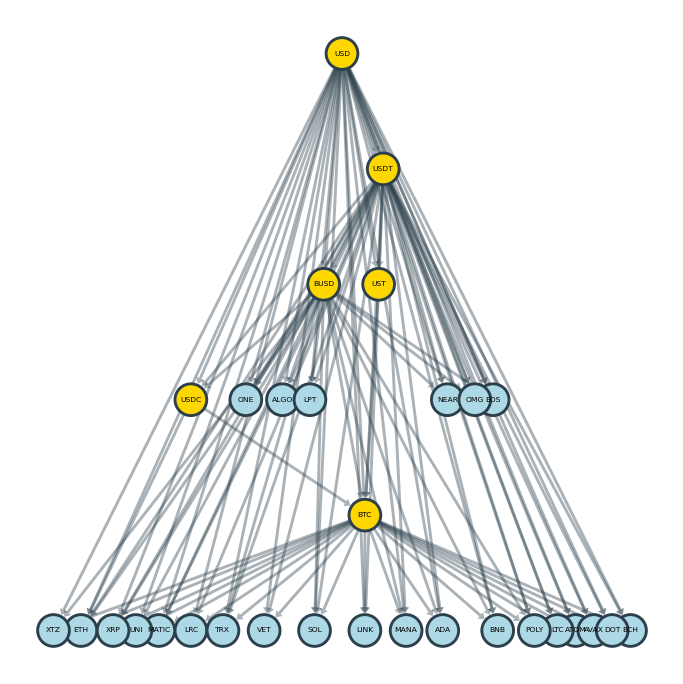

In [30]:
def netgraph_dg(dg):

    fig = plt.figure(figsize=(12, 18))
    Graph(
        dg,
        arrows=True,
        node_layout="dot",
        node_labels=True,
        node_size=3,
        node_color={node: dg.nodes[node]["color"] for node in dg.nodes()},
        edge_width=0.5,
        edge_alpha=0.4,
    )
    
netgraph_dg(dg_symbols)

Nodes of a directed graph are characterized incoming and outgoing edges. A node's in-degree refers to the number of incoming edges, out-degree refers to the number of outgoing edges. In this case, node with outgoing edges are highlighted because they represent currencies used to quote the price of other currencies. The currency nodes have only in-coming edge. Nodes with only one incoming edge are not candidates for arbitrage. A parameter `in_degree` specifies a minimum threshold value for these nodes to be retained for further analysis.

Number of nodes =  31
Number of edges =  98


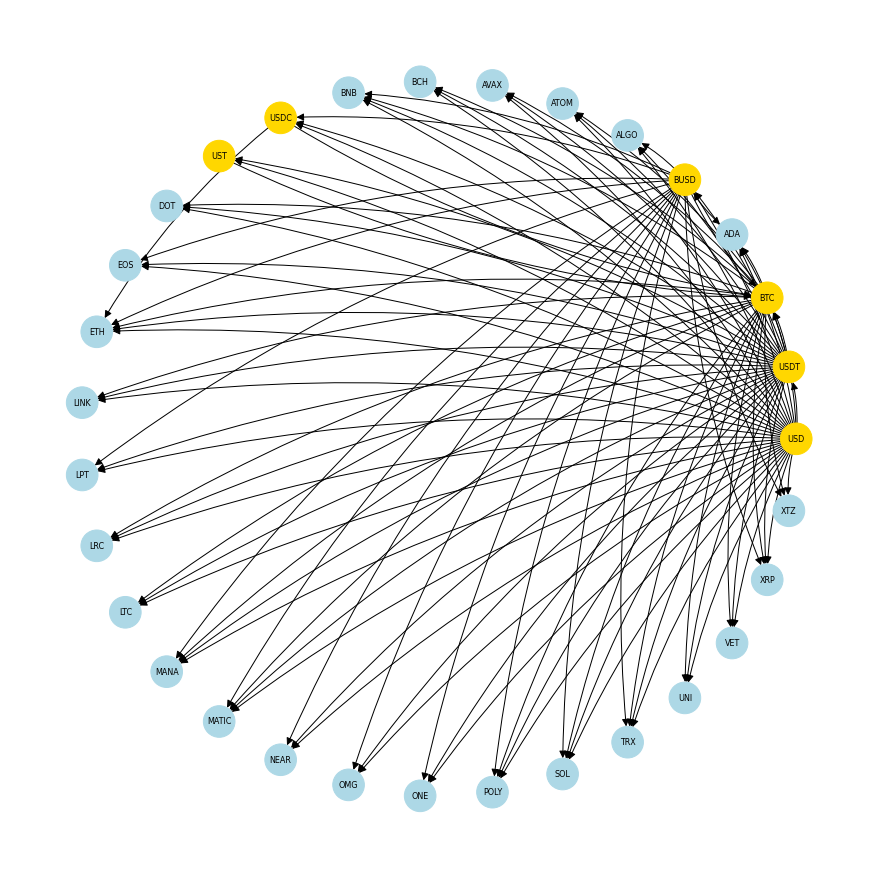

In [31]:
def draw_dg(dg):
    print(f"Number of nodes = {len(dg.nodes()):3d}")
    print(f"Number of edges = {len(dg.edges()):3d}")
    
    fig = plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(dg)
    nx.draw(
        dg,
        pos,
        with_labels=True,
        node_color=[dg.nodes[node]["color"] for node in dg.nodes()],
        node_size=1000,
        font_size=8,
        arrowsize=15,
        connectionstyle="arc3, rad=0.1",
    )
    # nx.draw_networkx_edge_labels(
    #    G, pos, edge_labels={(src, dst): f"{src}/{dst}" for src, dst in dg.edges()}
    # )


draw_dg(dg_symbols)

## An Exchange Order Book

An currency exchange order book presents a real-time inventory of trading orders. 

A **bid** is an order to buy some amount of the base currency at a price given in the quote currency. The buyer will receive the base currency if a transaction occurs. The price paid may be less than bid price if the exchange matches the bid to a previous offer to sell at a lower price. The size the transaction is specified in terms of the base currency that is bought or sold.

An **ask** is an offer to sell an amount of the base currency at a quoted price. If a transaction occurs, then seller receives the quote currency at a unit price that may be higher if the exchange matches the ask order to a higher bid.

The exchange order book maintains a list of all active orders for all symbols traded on the exchange. The highest bid will below the lowest ask. Incoming bids above the lowest ask, or incoming asks below the highest bid, will be matched and transactions executed following exchange rules. 

The following cell fetches the highest bid and lowest ask from the order book for 

In [32]:
import pandas as pd

def fetch_order_book(dg):

    # get trading symbols from exchange graph
    trade_symbols = ["/".join([base, quote]) for quote, base in dg.edges()]

    def fetch_order_book_symbol(symbol, limit=1, exchange=exchange):
        """return order book data for a specified symbol"""
        start_time = timer()
        result = exchange.fetch_order_book(symbol, limit)
        result["base"], result["quote"] = symbol.split("/")
        result["run_time"] = timer() - start_time
        result["timestamp"] = exchange.milliseconds()
        if result["bids"]:
            result["bid_price"] = result["bids"][0][0]
            result["bid_volume"] = result["bids"][0][1]
        if result["asks"]:
            result["ask_price"] = result["asks"][0][0]
            result["ask_volume"] = result["asks"][0][1]
        return result

    # fetch order book data and store in a dictionary
    order_book = {symbol: fetch_order_book_symbol(symbol) for symbol in trade_symbols}

    # convert to pandas dataframe
    order_book = pd.DataFrame(order_book).T
    order_book.drop(columns=["datetime", "symbol"], inplace=True)
    order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")

    return order_book


order_book = fetch_order_book(dg_symbols)
display(order_book)

,bids,asks,timestamp,nonce,base,quote,run_time,bid_price,bid_volume,ask_price,ask_volume
ADA/USD,"[[0.575, 840.0]]","[[0.5754, 870.3]]",2022-05-13 10:40:46.019,953297902,ADA,USD,0.056427,0.575,840.0,0.5754,870.3
ALGO/USD,"[[0.476, 17346.103]]","[[0.477, 3340.225]]",2022-05-13 10:40:46.072,297337770,ALGO,USD,0.053172,0.476,17346.103,0.477,3340.225
ATOM/USD,"[[10.893, 4.475]]","[[10.904, 21.2]]",2022-05-13 10:40:46.123,598245086,ATOM,USD,0.050757,10.893,4.475,10.904,21.2
AVAX/USD,"[[34.55, 24.56]]","[[34.58, 19.2]]",2022-05-13 10:40:46.176,197417499,AVAX,USD,0.05276,34.55,24.56,34.58,19.2
BCH/USD,"[[209.6, 0.19068]]","[[209.82, 0.19064]]",2022-05-13 10:40:46.228,664237797,BCH,USD,0.051721,209.6,0.19068,209.82,0.19064
...,...,...,...,...,...,...,...,...,...,...,...
XRP/BUSD,[],[],2022-05-13 10:40:50.900,28045681,XRP,BUSD,0.051575,NaN,NaN,NaN,NaN
XTZ/BUSD,"[[1.85, 137.83]]","[[1.854, 104.84]]",2022-05-13 10:40:50.954,114139020,XTZ,BUSD,0.053596,1.85,137.83,1.854,104.84
BTC/USDC,"[[30302.67, 0.32]]","[[30333.88, 0.054327]]",2022-05-13 10:40:51.013,198679959,BTC,USDC,0.059116,30302.67,0.32,30333.88,0.054327
ETH/USDC,"[[2076.25, 0.288]]","[[2079.35, 0.288]]",2022-05-13 10:40:51.064,34096805,ETH,USDC,0.051345,2076.25,0.288,2079.35,0.288


## Order Book as a Directed Graph

Here we visual the order book as a directed graph. Each order for a particular symbol is represented as an edge. Consider a symbol with base currency $b$ and quote currency $q$, with a corresponding trading symbol $b/q$. 

The appearance of a sell order for symbol $b/q$ in the order book presents an opportunity to purchase an amount of currency $b$ at the specified ask price. This opportunity is represented on the directed graph by a directed edge from the quote currency to the base currency with a 'conversion' value $a_{q\rightarrow b}$ equal to inverse of the ask price. The conversion means that one unit of the quote currency can be converted to $a_{q\rightarrow b}$ units of the base currency. The capacity of the edge is the ask volume multiplied by the ask price.

A buy order for symbol $b/q$ presents an opportunity to sell an amount of currency $b$ at the specified bid price. The is represented by a directed edge from the base currency to the quote currency with a conversion value $a_{b\rightarrow q}$ equal to the bid price. The conversion means that one unit of the base currency can be converted to $a_{b\rightarrow q}$ units of the quote currency. The capacity of the edge is equal to bid volume.

Number of nodes =  31
Number of edges = 188


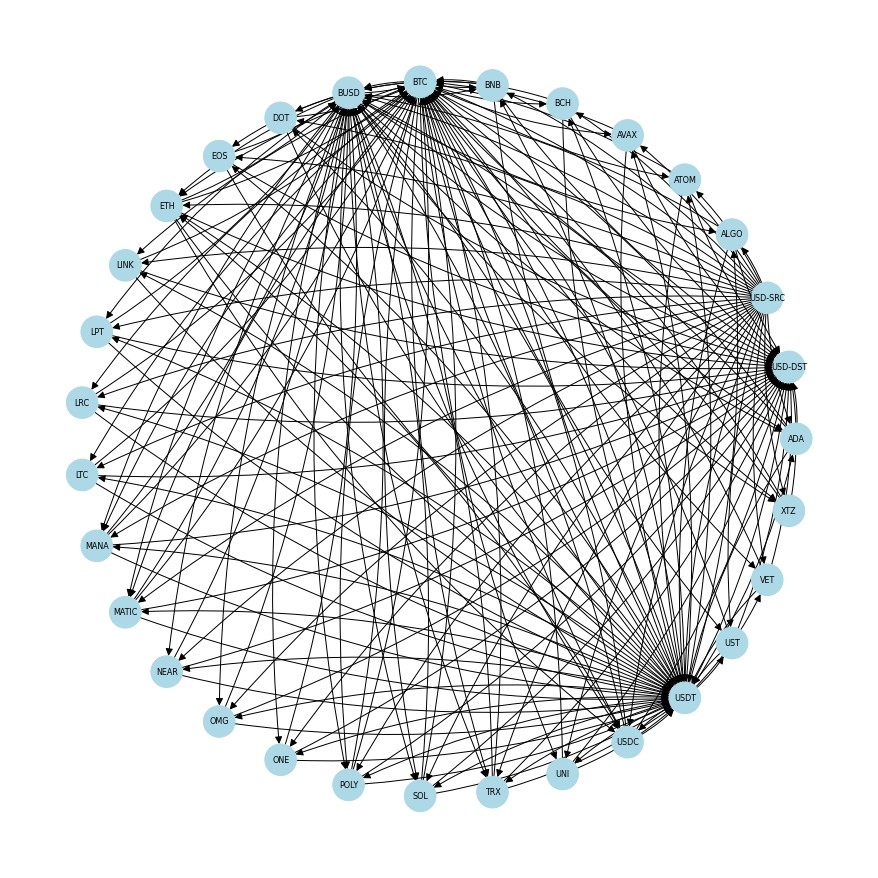

In [33]:
# dictionary of edges for (src, dst) tuples
#     type: 'bid' or 'ask'
#     conv: 1 unit of src currency produces conv units of dst currency
#     log10_conv: log10 of conv

def order_book_to_dg(order_book):

    edges = dict()
    
    for symbol in order_book.index:
        # 
        if not np.isnan(order_book.at[symbol, "bid_volume"]):
            src = order_book.at[symbol, "base"]
            if src == "USD":
                src = "USD-SRC"
            dst = order_book.at[symbol, "quote"]
            if dst == "USD":
                dst = "USD-DST"
            edges[(src, dst)] = {
                "type": "bid",
                "conv": order_book.at[symbol, "bid_price"],
                "log10_conv": np.log10(order_book.at[symbol, "bid_price"]),
                "capacity": order_book.at[symbol, "bid_volume"],
            }
        if not np.isnan(order_book.at[symbol, "ask_volume"]):
            src = order_book.at[symbol, "quote"]
            if src == "USD":
                src = "USD-SRC"
            dst = order_book.at[symbol, "base"]
            if dst == "USD":
                dst = "USD-DST"
            edges[(src, dst)] = {
                "type": "ask",
                "conv": 1.0 / order_book.at[symbol, "ask_price"],
                "log10_conv": np.log10(1.0 / order_book.at[symbol, "ask_price"]),
                "capacity": order_book.at[symbol, "ask_volume"] * order_book.at[symbol, "ask_price"],
            }

    dg_order_book = nx.DiGraph()
    
    for (src, dst), data in edges.items():
        dg_order_book.add_edge(src, dst, weight = -data["log10_conv"])
        
    for node in dg_order_book.nodes():
        dg_order_book.nodes[node]["color"] = "lightblue"
        
    return dg_order_book

dg_order_book = order_book_to_dg(order_book)

draw_dg(dg_order_book)

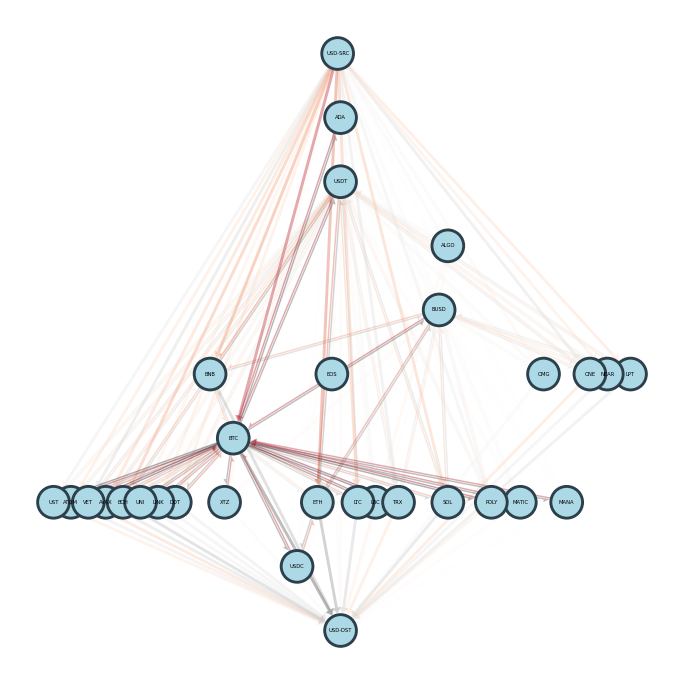

In [17]:
netgraph_dg(dg_order_book)

## Finding Arbitrage as Shortest Path

In [18]:
def dg_shortest_path(dg_order_book):
    shortest_path = nx.shortest_path(
        dg_order_book, "USD-SRC", "USD-DST", weight="weight", method="bellman-ford"
    )

    S = 1.0
    x = np.inf
    for src, dst in zip(shortest_path, shortest_path[1:]):
        print(f"Sell {src}, Buy {dst}:")

        cap = edges[(src, dst)]["capacity"]
        a = edges[(src, dst)]["conv"]
        print(f"     Max {src} on-hand = {x}")
        print(f"     Max trade = {cap} {src}")

        a = edges[(src, dst)]["conv"]
        S = S * a
        x = a * min(cap, x)

        print(f"     Price = {a} {dst} per {src}")
        print(f"     Max position after trade {dst} = {x}")

        print()

    print("Summary")
    print(f"Starting Position {x/S} USD")
    print(f"Final Position {x} USD")
    print(f"Net profit = {x - x/S}  ({100*(1 - 1/S):.5f}%)")
    
dg_shortest_path(dg_order_book)

NetworkXUnbounded: Negative cycle detected.

In [ ]:
order_book = fetch_order_book(dg_symbols)
dg_order_book = order_book_to_dg(order_book)
dg_shortest_path(dg_order_book)

## Optimizing Wealth Creation

In [555]:
import pyomo.environ as pyo

T = 10

m = pyo.ConcreteModel(f"{exchange} arbitrage")

# length of the trading chain
m.T0 = pyo.RangeSet(0, T)
m.T1 = pyo.RangeSet(1, T)

# currency nodes and trading edges
m.NODES = pyo.Set(initialize=nodes.keys())
m.EDGES = pyo.Set(initialize=edges.keys())

# "gain" on each trading edge
@m.Param(m.EDGES)
def a(m, src, dst):
    return 10 ** edges[(src, dst)]["log10_conv"]


# currency on hand at each node
m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

# amount traded on each edge
m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)


@m.Objective(sense=pyo.maximize)
def wealth(m):
    return m.w["USD-DST", T]


# initial assignment of 100 units on a selected currency
@m.Constraint(m.NODES)
def initial(m, node):
    if node == "USD-SRC":
        return m.w[node, 0] == 1.0
    return m.w[node, 0] == 0.0


@m.Constraint(m.NODES, m.T1)
def no_shorting(m, node, t):
    return m.w[node, t - 1] >= sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    )


@m.Constraint(m.NODES, m.T1)
def balances(m, node, t):
    return m.w[node, t] == m.w[node, t - 1] - sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    ) + sum(m.a[src, node] * m.x[src, node, t] for src, dst in m.EDGES if dst == node)


solver = pyo.SolverFactory("cbc")
solver.solve(m)

for node in m.NODES:
    print(f"{node:8s}", end="")
    for t in m.T0:
        print(f" {m.w[node, t]():12.8f}", end="")
    print()

print()

for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():0.8f}")
    print()

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
import math

n = len(nodes)


def visualize(bf):
    adot = Digraph()
    for node in bf.keys():
        w = 10 ** (-bf[node]["w"])
        if math.isinf(w):
            adot.node(node)
        else:
            adot.node(node, label=f"{node}\n{w:0.8f}")
        if bf[node]["prec"] is not None:
            adot.edge(bf[node]["prec"], node)
    display(adot)


# dictionary of all nodes.
#   prec: preceding node
#   w: weight

bf = {node: {"prec": None, "w": float("inf")} for node in nodes}
bf["USD-SRC"]["w"] = 0

for _ in range(n - 1):
    for edge in edges.keys():
        src, dst = edge
        w = -edges[edge]["log10_conv"]
        if bf[dst]["w"] > (bf[src]["w"] + w):
            bf[dst]["w"] = bf[src]["w"] + w
            bf[dst]["prec"] = src

visualize(bf)

## Appendix: Asynchronous downloads of order book data

Considerably more development, testing, and validation would be needed to adapt this code to an automated tradign bot to exploit arbitrage opportunities in the crypto-currency markets. One of the time consuming steps is accessing order book data. The following cell is an experiment using the Python `asyncio` library to determine if asynchronous calls to the `ccxt` would provide faster downloads. 

Preliminary testing shows little or no advantage to `asyncio` when working with a single exchange. That may change when the above code is adapted to multi-exchange arbitrage, and therefore this code is retained below for future testing.

In [15]:
%%script echo skipping

from timeit import default_timer as timer

# asynchronous implementation
import asyncio
import nest_asyncio

my_symbols = ['/'.join(edge) for edge in edges]

async def afetch_order_book(symbol, limit=1, exchange=exchange):
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    run_time = timer() - start_time
    return result

async def get_data():
    coroutines = [afetch_order_book(symbol) for symbol in my_symbols]
    await asyncio.gather(*coroutines)

start = timer()
nest_asyncio.apply()
asyncio.run(get_data())
run_time = timer() - start

print(run_time)

skipping


In [7]:
# trim currencies to those that appears as DST, or are N or more SRC

# all currencies trading in N or more base currencies
N = 4

src_nodes = list(src_count[src_count > N].index)
dst_nodes = list(dst_count[dst_count > 1].index)
src_dst_nodes = list(set(src_nodes + dst_nodes))

# plot a directed graph from the edges and nodes
label = f"{exchange}\ntrading symbols with {N} or more base currencies\n "
dg = Digraph(
    f"{exchange}",
    graph_attr={"label": label, "fontsize": "15", "labelloc": "t"},
    node_attr={"fontsize": "12"},
    edge_attr={"fontsize": "10"},
)

for node in src_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="lightblue")

for node in dst_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="gold")

trade_edges = [
    [src, dst]
    for src, dst in src_dst_pairs
    if (src in src_dst_nodes) and (dst in src_dst_nodes)
]
for src, dst in trade_edges:
    symbol = "/".join([src, dst])
    label = f"{symbol}"
    dg.edge(src, dst, label)

display(dg)
dg.format = "png"
dg.view("exchange-symbol-map")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH